In [64]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import corner
import matplotlib
from numpy.linalg import svd
import scipy.stats as ss
from matplotlib import gridspec
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import scipy.interpolate as si
import os
import glob
import bilby
import json



In [65]:
# Main codes

def reorder_dphip (dphip):
    dphip_reordered = dphip*0.0;
    for i in range(dphip.shape[1]):
        dphip_reordered[:,i] = dphip[:,dphip.shape[1]-1-i]; #reverses the column order from leading to subleading PCA parameters
    return dphip_reordered;

def get_dphip_reordered (dchi):
    
    '''
    Parameters: posterior samples for deformation parameters sampled over 
    Returns: posterior samples for the PCA linear combinations
    '''
    
    C = np.cov(np.transpose(dchi));             # Covariance matrix from the samples
    U, S, V = svd(np.matrix(C));                # diagonalization

    dphip = dchi*0.0;                           # dphip is the set of new parameters (after transforming dchi)
    for i in range(len(dchi)):
        dphip[i,:] = np.transpose(np.matrix(V) * np.transpose(np.matrix(dchi[i,:]))); # Transform the original samples
    return reorder_dphip (dphip)                #reverses the column order from leading to subleading PCA parameters


In [66]:
#auxiliary codes

def load_hdf5 (filename):
    f = h5py.File(filename, 'r');
    posterior = f['lalinference']['lalinference_nest']['posterior_samples'][()];
    return posterior

def load_json (filename):
    with open(filename, 'r') as file:
        metadata = json.load(file)
    posterior = metadata['posterior']['content']
    return posterior

def extract_dchi (data, plist):
    par0 = 'dchi'+ plist[0]
    dchi = np.zeros([len(data[par0]),len(plist)]);
    for i in range(len(plist)):
        dchi[:,i] = data['dchi'+plist[i]];
    return dchi

In [67]:
#MDC
pathname1 = '/home/sayantani.datta/O4-PCA/repo/pca_tgr/pca/code_demo/samples/GW170608-like_aligned_spin_TEOBResumS_lmax5_srate_4096_alpha2_100_no_wf_scaling-6p.json'
# GW151226-like
pathname2 = '/home/sayantani.datta/O4-PCA/repo/pca_tgr/pca/code_demo/samples/GW151226_like_GR_6p.hdf5'

In [68]:
# PN deformation parameters sampled over
plist=['3','4','5l','6','6l','7']

In [69]:
load_samples = load_hdf5 (pathname2)

# Extract samples for deformation parameters in plist
dchi_samples = extract_dchi (data = load_samples, plist = plist)
# Perform PCA
pca_samples = get_dphip_reordered (dchi_samples)

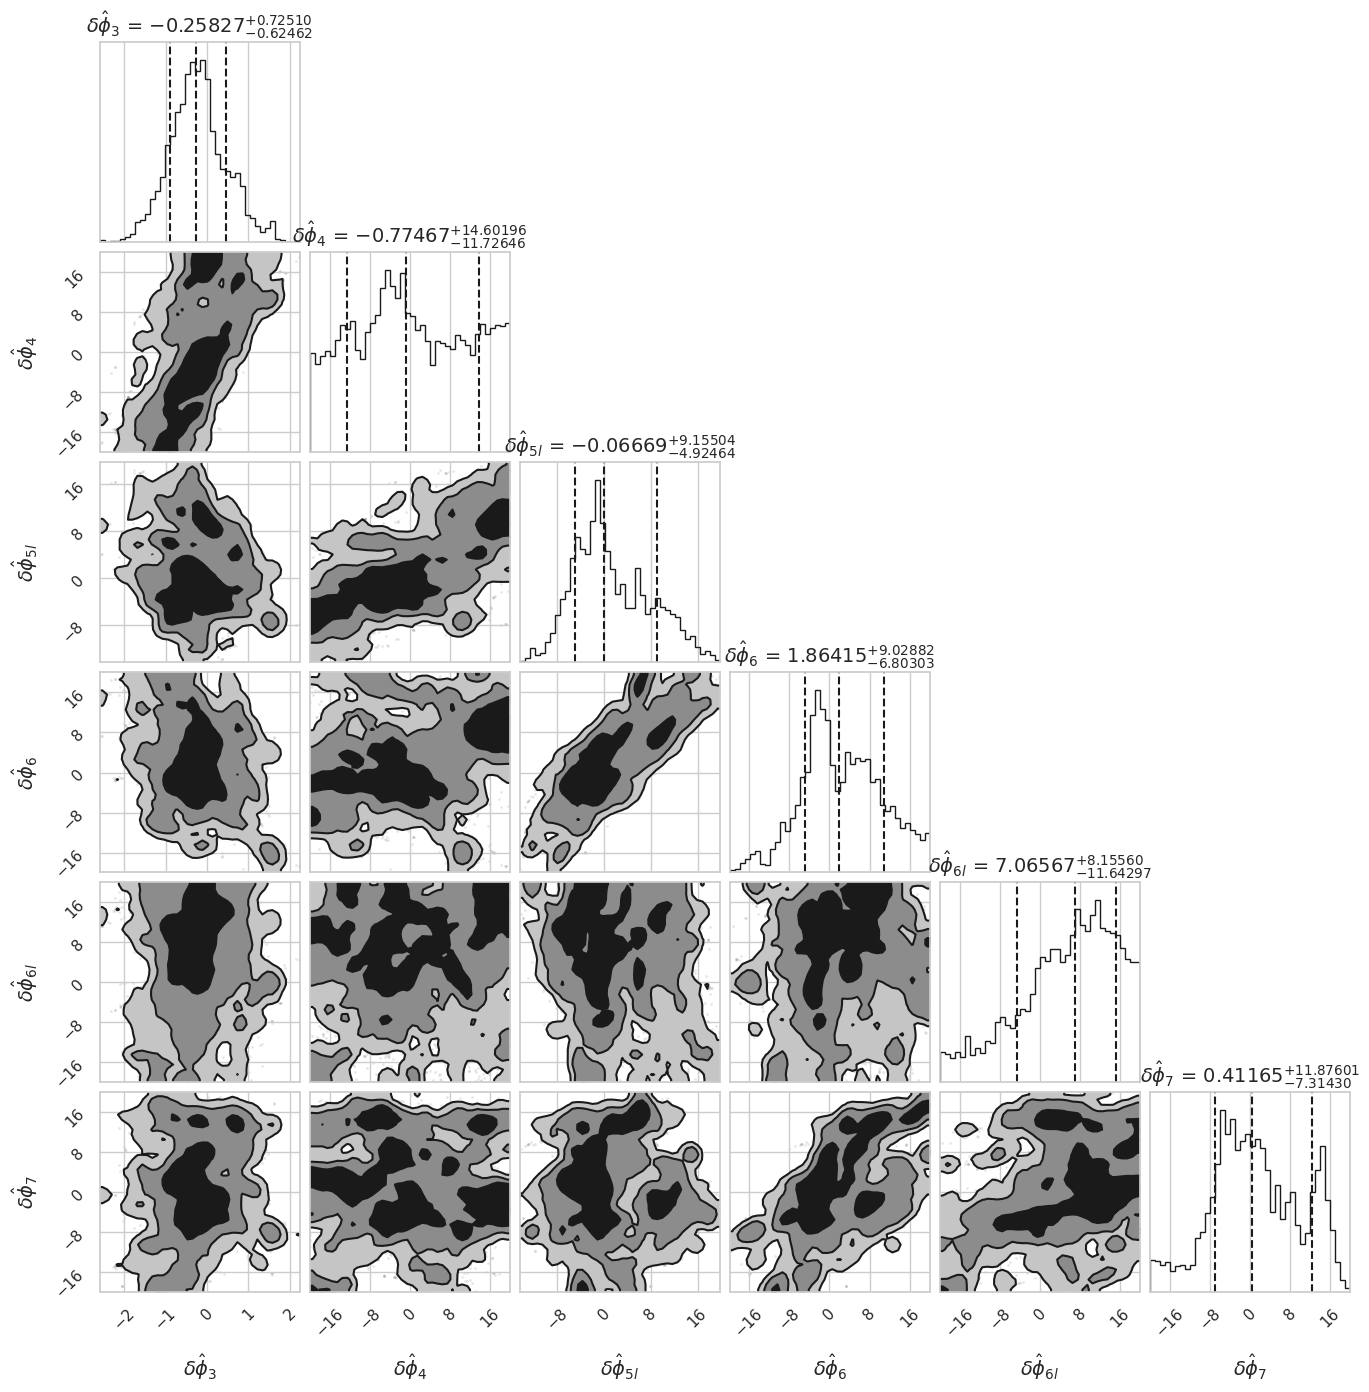

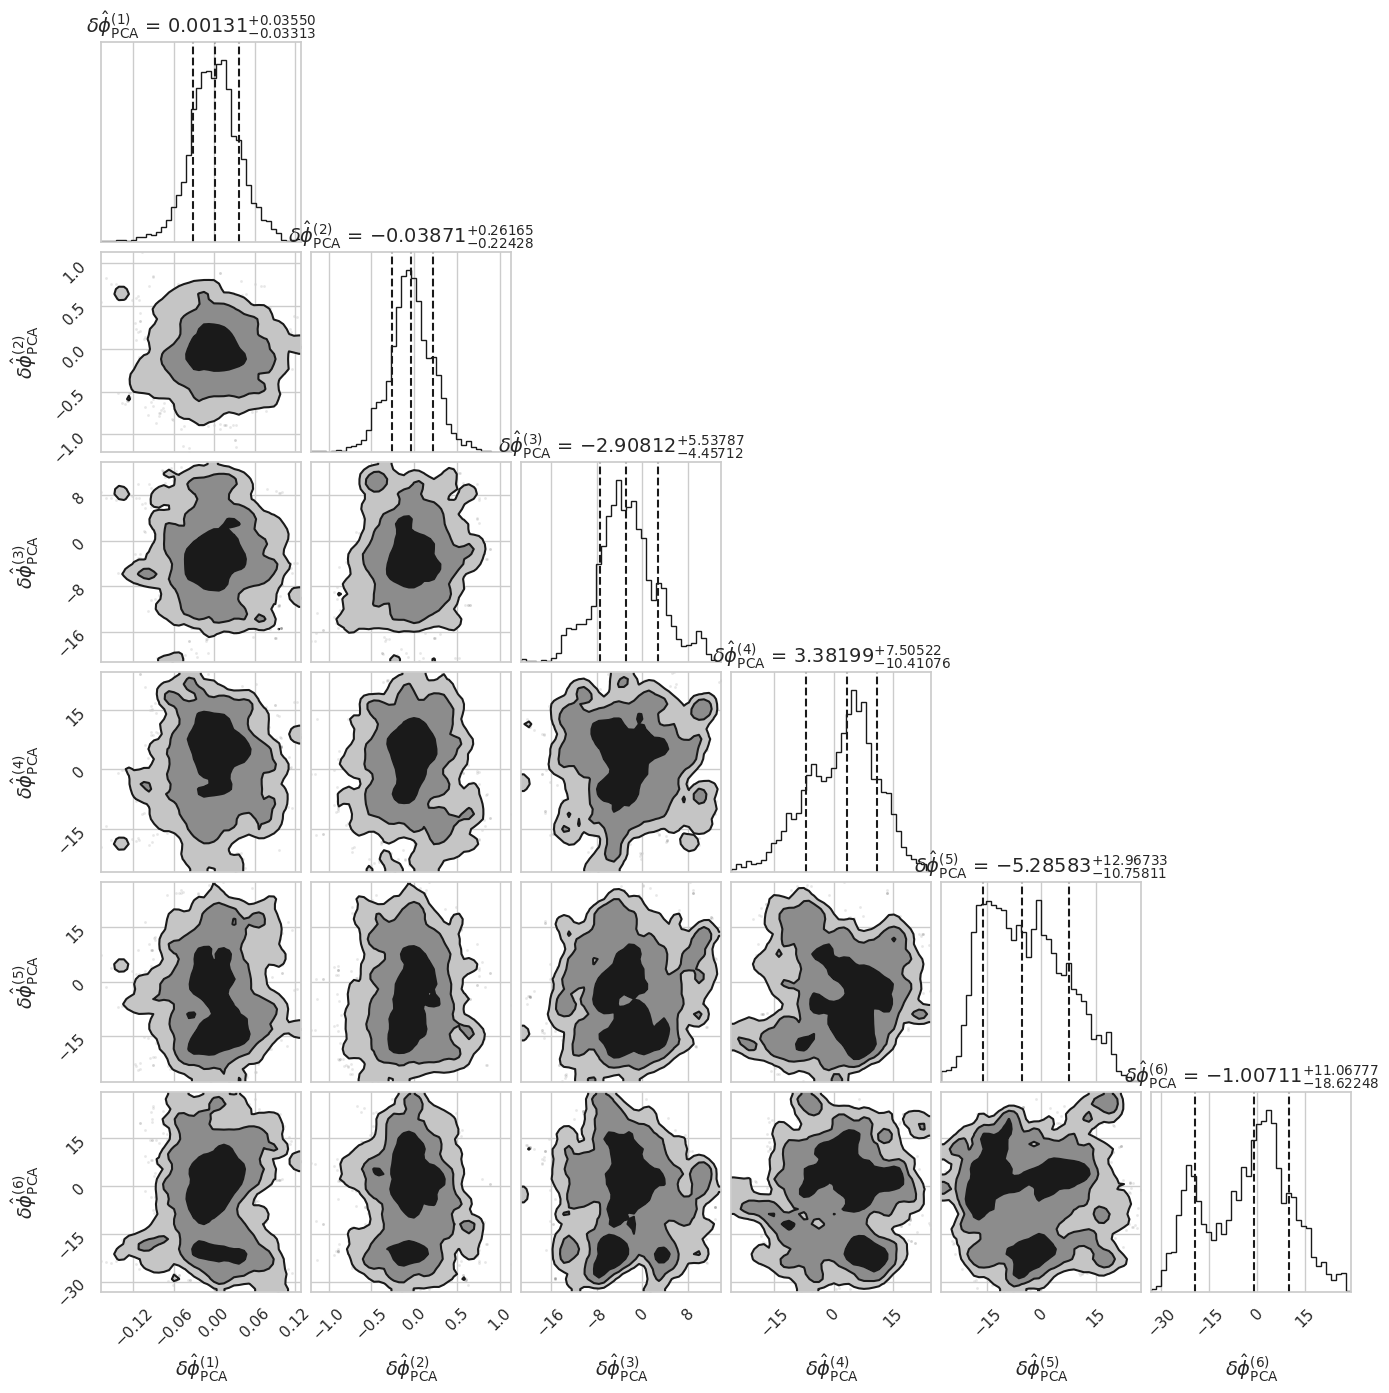

In [70]:
#corner plot of the results

corner_kwargs_pca = dict(bins=40, smooth=0.9, label_kwargs=dict(fontsize=14),
            title_kwargs=dict(fontsize=14),show_titles=True,title_fmt ='.5f', color='k',
            truth_color='tab:orange', quantiles=[0.16, 0.5, 0.84],
            #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
            levels = (0.5, 0.9,0.99),
            plot_density=False, plot_datapoints=True, fill_contours=True,
            max_n_ticks=5)

corner_kwargs_nonpca = dict(bins=40, smooth=0.9, label_kwargs=dict(fontsize=14),
            title_kwargs=dict(fontsize=14),show_titles=True,title_fmt ='.5f', color='k',
            truth_color='tab:orange', quantiles=[0.16, 0.5, 0.84],
            levels = (0.5, 0.9,0.99),
            plot_density=False, plot_datapoints=True, fill_contours=True,
            max_n_ticks=5)

labels_nonpca = [r'$\delta\hat\phi_{3}$',r'$\delta\hat\phi_{4}$',r'$\delta\hat\phi_{5l}$',
                 r'$\delta\hat\phi_{6}$',r'$\delta\hat\phi_{6l}$',r'$\delta\hat\phi_{7}$']

labels_pca = [r'$\delta\hat\phi_{\rm PCA}^{(1)}$', r'$\delta\hat\phi_{\rm PCA}^{(2)}$', 
              r'$\delta\hat\phi_{\rm PCA}^{(3)}$', r'$\delta\hat\phi_{\rm PCA}^{(4)}$', 
              r'$\delta\hat\phi_{\rm PCA}^{(5)}$',r'$\delta\hat\phi_{\rm PCA}^{(6)}$']

figure_nonpca = corner.corner(dchi_samples, labels=labels_nonpca,**corner_kwargs_nonpca)
figure_pca = corner.corner(pca_samples, labels=labels_pca,**corner_kwargs_pca)


In [71]:
# Step by step demonstration

def reorder_dphip_demo (dphip):
    
    dphip_reordered = dphip*0.0;
    for i in range(dphip.shape[1]):                         #loop runs over the columns/no. of PCA parameters
        dphip_reordered[:,i] = dphip[:,dphip.shape[1]-1-i]; #reverses the column order from leading to subleading PCA parameters
    return dphip_reordered;


def get_dphip_reordered_demo (dchi):
    
    C = np.cov(np.transpose(dchi)); 
    
    print('Covariance matrix:\n', C)
    eigenvalues = np.linalg.eigvals(C)
    print('Eigenvalues:', eigenvalues)        # Eigenvalues are all positive, C is positive semi-definite
    
    
    U, S, V = svd(np.matrix(C));              # C = U S V^T  with V = U when C is symmetric
    
    print('\nU:\n', U)
    print('\nV:\n', np.transpose(V))
    
    
    unitarityU = np.matrix(U)*np.transpose(U) # UU^T = I
    print('\nUU^T:\n ',  unitarityU)
    unitarityV = np.matrix(V)*np.transpose(V) # VV^T = I
    print('\nVV^T:\n ',  unitarityV)
    print('\nSingular values:\n', S)

    dphip = dchi*0.0; 
    for i in range(len(dchi)):                                                         # Transform the original samples
        dphip[i,:] = np.transpose(np.matrix(V) * np.transpose(np.matrix(dchi[i,:])));  # [\theta_{PCA}] = [U]^T * [\theta] 
        
    
    return reorder_dphip_demo (dphip)         #reverses the column order from leading to subleading PCA parameters                                                 




In [72]:
pca_samples_demo = get_dphip_reordered_demo (dchi_samples)

Covariance matrix:
 [[  0.46534036   4.55903939  -0.50552488  -1.31011412   0.4592668
    0.73790544]
 [  4.55903939 124.30700346  50.4044185   30.89166075   9.65651828
   -4.35259209]
 [ -0.50552488  50.4044185   42.80342033  40.74780419  -6.52610381
    1.21483503]
 [ -1.31011412  30.89166075  40.74780419  62.63521318   8.04537417
   40.71277365]
 [  0.4592668    9.65651828  -6.52610381   8.04537417  90.45489281
   26.84993745]
 [  0.73790544  -4.35259209   1.21483503  40.71277365  26.84993745
   77.12745722]]
Eigenvalues: [1.72964272e+02 1.18695556e+02 7.81778682e+01 2.78906763e+01
 1.32585048e-03 6.36295509e-02]

U:
 [[-0.01620532  0.00990422  0.02873831  0.11017459  0.24860575  0.96170169]
 [-0.7390185   0.37209722  0.32551832  0.42861711  0.12018829 -0.10618514]
 [-0.42128828  0.16079528 -0.19682806 -0.46289553 -0.70015467  0.23115135]
 [-0.45205123 -0.23676446 -0.4464655  -0.42469457  0.59214041 -0.09625538]
 [-0.16580315 -0.59628448  0.72368157 -0.30261884 -0.0323725   0.024758